# Importes basicos "pandas numpy ..."


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle, time

%matplotlib inline

# Carregamento dos conjuntos de dados

In [3]:
!git clone https://github.com/InfraSchools/analiseDados.git

Cloning into 'analiseDados'...
remote: Enumerating objects: 115, done.
remote: Counting objects: 100% (115/115), done.
remote: Compressing objects: 100% (82/82), done.
remote: Total 232 (delta 62), reused 68 (delta 29), pack-reused 117
Receiving objects: 100% (232/232), 57.58 MiB | 11.75 MiB/s, done.
Resolving deltas: 100% (116/116), done.
Checking out files: 100% (80/80), done.


In [0]:
data = pd.read_csv('analiseDados/base/Base_Completa.csv', encoding = 'iso-8859-1', sep=';',  low_memory=False)
data = data[data.TAXA_PARTICIPACAO_5EF!=0]

In [0]:
def pega_data(df, tipe, rotulo):
  q1 = df[tipe].quantile(q=0.25)
  q4 = df[tipe].quantile(q=0.75)
  
  df1Q = df[df[tipe]<q1]
  df4Q = df[df[tipe]>q4]

  #print(df1Q, df4Q)
  
  df1Q.loc[:,rotulo] = 0
  df4Q.loc[:,rotulo] = 1
  
  return  pd.concat([df4Q , df1Q])

In [14]:
base_LP = pega_data(data, 'MEDIA_5EF_LP', 'ROTULO')
#base_MT = pega_data(data, 'MEDIA_5EF_MT', 'ROTULO')

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


# Separação dos dados para trenamentos 

In [0]:
atributos = ["TAXA_PARTICIPACAO_5EF", "TP_DEPENDENCIA", "IN_AGUA_INEXISTENTE", "IN_ENERGIA_INEXISTENTE", "IN_ESGOTO_INEXISTENTE","IN_LABORATORIO_INFORMATICA", "IN_LABORATORIO_CIENCIAS", "IN_QUADRA_ESPORTES", "IN_BIBLIOTECA_SALA_LEITURA", "IN_PATIO_COBERTO", "IN_SALA_DIRETORIA", "IN_SALA_PROFESSOR", "IN_AUDITORIO", "IN_DEPENDENCIAS_PNE", "IN_EQUIP_TV","IN_EQUIP_COPIADORA", "IN_EQUIP_RETROPROJETOR", "IN_EQUIP_IMPRESSORA", "IN_EQUIP_SOM", "IN_COMPUTADOR", "IN_INTERNET", "CO_UF", "CO_REGIAO"]

X = base_LP.loc[:, atributos ].values
y = base_LP.loc[:,'ROTULO'].values

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)

# ANN

In [0]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Flatten
%tensorflow_version 1.x

def crear_model(opt):
	model = Sequential()
	model.add(Dense(units = len(atributos), kernel_initializer = 'uniform', activation = 'relu', input_dim = len(atributos)))
	model.add(Dense(units = 15, kernel_initializer = 'uniform', activation = 'relu')) #10
	model.add(Dense(units = 10, kernel_initializer = 'uniform', activation = 'softmax')) #5
	model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid')) # softmax sigmoid
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

In [43]:
modelo = crear_model('adam')
modelo.summary()

arg_epochs = 9
# Treina o modelo
history = modelo.fit(X_train, y_train, epochs=arg_epochs, batch_size=1, validation_data=(X_test, y_test))

from sklearn.metrics import classification_report, confusion_matrix
print("[INFO] ANN...\n")
y_pred = modelo.predict(X_test, batch_size=1)
y_predic =(y_pred>0.5)
print(confusion_matrix(y_test, y_predic))
print(classification_report(y_test, y_predic, target_names=['Infraestrutura prejudicial', 'Infraestrutura nao prejudicial']))

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 23)                552       
_________________________________________________________________
dense_18 (Dense)             (None, 15)                360       
_________________________________________________________________
dense_19 (Dense)             (None, 10)                160       
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 11        
Total params: 1,083
Trainable params: 1,083
Non-trainable params: 0
_________________________________________________________________
Train on 16715 samples, validate on 7164 samples
Epoch 1/9
16715/16715 [==============================] - 32s 2ms/step - loss: 0.4578 - acc: 0.8246 - val_loss: 0.4094 - val_acc: 0.8516
Epoch 2/9
16715/16715 [==============================] - 32s 2ms/

In [0]:
#from keras.utils import plot_model
#plot_model(modelo, to_file='modelo.png')

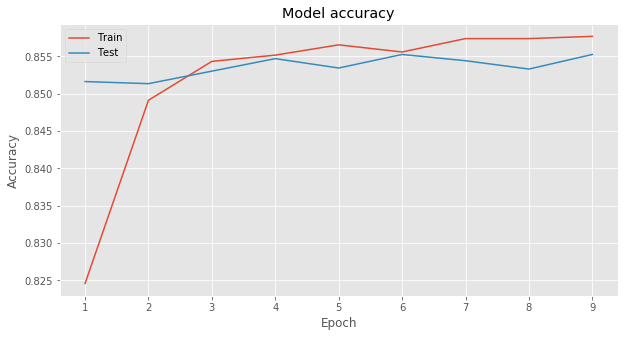

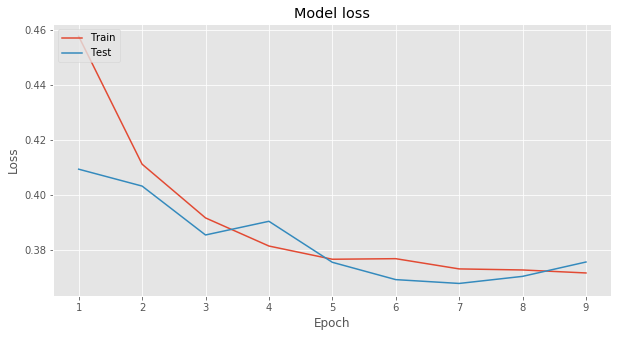

In [44]:
epochs = range(1, len(history.history['loss']) + 1)

plt.style.use("ggplot")
plt.figure(figsize=(10,5))
# Plot training & validation accuracy values
plt.plot(epochs, history.history['acc'])
plt.plot(epochs, history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.style.use("ggplot")
plt.figure(figsize=(10,5))
# Plot training & validation loss values
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [0]:
modelo.save('ANN.model')
modelo.save_weights('ANN.weights')

# SVM

In [28]:
from sklearn.svm import SVC
svclassifier = SVC(kernel='linear')
svclassifier.fit(X_train, y_train)

y_pred = svclassifier.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix
print("[INFO] SVC-linear ...\n")

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[INFO] SVC-linear ...

[[3134  419]
 [ 621 2990]]
              precision    recall  f1-score   support

           0       0.83      0.88      0.86      3553
           1       0.88      0.83      0.85      3611

    accuracy                           0.85      7164
   macro avg       0.86      0.86      0.85      7164
weighted avg       0.86      0.85      0.85      7164



In [26]:
from sklearn.svm import SVC
svclassifier = SVC(kernel='rbf')
svclassifier.fit(X_train, y_train)

y_pred = svclassifier.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix
print("[INFO] SVC-rbf ...\n")

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[INFO] SVC-rbf ...

[[3179  374]
 [ 470 3141]]
              precision    recall  f1-score   support

           0       0.87      0.89      0.88      3553
           1       0.89      0.87      0.88      3611

    accuracy                           0.88      7164
   macro avg       0.88      0.88      0.88      7164
weighted avg       0.88      0.88      0.88      7164



In [27]:
from sklearn.svm import SVC
svclassifier = SVC(kernel='sigmoid')
svclassifier.fit(X_train, y_train)

y_pred = svclassifier.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix

print("[INFO] SVC-sigmoid ...\n")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[INFO] SVC-rbf ...

[[ 604 2949]
 [ 189 3422]]
              precision    recall  f1-score   support

           0       0.76      0.17      0.28      3553
           1       0.54      0.95      0.69      3611

    accuracy                           0.56      7164
   macro avg       0.65      0.56      0.48      7164
weighted avg       0.65      0.56      0.48      7164



# Random Forest

In [0]:
df = data.copy()
metade = df['MEDIA_5EF_LP'].quantile(q=0.50)
df['ROTULO'] = list(map(lambda x : 1 if x>metade else 0, df.loc[:,'MEDIA_5EF_LP']))


X = df[['IN_AGUA_FILTRADA','IN_AGUA_REDE_PUBLICA','IN_AGUA_POCO_ARTESIANO','IN_AGUA_CACIMBA'
,'IN_AGUA_FONTE_RIO','IN_AGUA_INEXISTENTE','IN_ENERGIA_REDE_PUBLICA','IN_ENERGIA_GERADOR'
,'IN_ENERGIA_OUTROS','IN_ENERGIA_INEXISTENTE','IN_ESGOTO_REDE_PUBLICA','IN_ESGOTO_FOSSA'
,'IN_ESGOTO_INEXISTENTE','IN_LIXO_COLETA_PERIODICA','IN_LIXO_QUEIMA'
,'IN_LIXO_JOGA_OUTRA_AREA','IN_LIXO_RECICLA','IN_LIXO_ENTERRA','IN_LIXO_OUTROS'
,'IN_SALA_DIRETORIA','IN_SALA_PROFESSOR','IN_LABORATORIO_INFORMATICA'
,'IN_LABORATORIO_CIENCIAS','IN_SALA_ATENDIMENTO_ESPECIAL','IN_QUADRA_ESPORTES_COBERTA'
,'IN_QUADRA_ESPORTES_DESCOBERTA','IN_QUADRA_ESPORTES','IN_COZINHA','IN_BIBLIOTECA'
,'IN_SALA_LEITURA','IN_BIBLIOTECA_SALA_LEITURA','IN_PARQUE_INFANTIL','IN_BERCARIO'
,'IN_BANHEIRO_FORA_PREDIO','IN_BANHEIRO_DENTRO_PREDIO','IN_BANHEIRO_EI','IN_BANHEIRO_PNE'
,'IN_DEPENDENCIAS_PNE','IN_SECRETARIA','IN_BANHEIRO_CHUVEIRO','IN_REFEITORIO','IN_DESPENSA'
,'IN_ALMOXARIFADO'
,'IN_AUDITORIO','IN_PATIO_COBERTO','IN_PATIO_DESCOBERTO'
,'IN_ALOJAM_ALUNO','IN_ALOJAM_PROFESSOR','IN_AREA_VERDE','IN_LAVANDERIA'
,'IN_DEPENDENCIAS_OUTRAS'
,'QT_SALAS_EXISTENTES','QT_SALAS_UTILIZADAS'
,'IN_EQUIP_TV','IN_EQUIP_VIDEOCASSETE','IN_EQUIP_DVD','IN_EQUIP_PARABOLICA'
,'IN_EQUIP_COPIADORA','IN_EQUIP_RETROPROJETOR'
,'IN_EQUIP_IMPRESSORA','IN_EQUIP_IMPRESSORA_MULT'
,'IN_EQUIP_SOM','IN_EQUIP_MULTIMIDIA'
,'IN_EQUIP_FAX','IN_EQUIP_FOTO'
,'IN_COMPUTADOR','QT_EQUIP_TV','QT_EQUIP_VIDEOCASSETE','QT_EQUIP_DVD','QT_EQUIP_PARABOLICA'
,'QT_EQUIP_COPIADORA','QT_EQUIP_RETROPROJETOR'
,'QT_EQUIP_IMPRESSORA','QT_EQUIP_IMPRESSORA_MULT','QT_EQUIP_SOM'
,'QT_EQUIP_MULTIMIDIA','QT_EQUIP_FAX','QT_EQUIP_FOTO','QT_COMPUTADOR'
,'QT_COMP_ALUNO','IN_INTERNET','IN_BANDA_LARGA','QT_FUNCIONARIOS'
,'IN_ALIMENTACAO'
,'TP_AEE'
,'TP_ATIVIDADE_COMPLEMENTAR'
,'IN_FUNDAMENTAL_CICLOS'
,'TP_LOCALIZACAO_DIFERENCIADA'
,'IN_MATERIAL_ESP_QUILOMBOLA'
,'IN_MATERIAL_ESP_INDIGENA'
,'IN_MATERIAL_ESP_NAO_UTILIZA'
,'IN_EDUCACAO_INDIGENA'
,'TP_INDIGENA_LINGUA'
,'CO_LINGUA_INDIGENA'
,'IN_BRASIL_ALFABETIZADO'
,'IN_FINAL_SEMANA'
,'IN_FORMACAO_ALTERNANCIA'
,'IN_MEDIACAO_PRESENCIAL'
,'IN_MEDIACAO_SEMIPRESENCIAL'
,'IN_MEDIACAO_EAD'
,'IN_ESPECIAL_EXCLUSIVA'
,'IN_REGULAR'
,'IN_EJA'
,'IN_PROFISSIONALIZANTE'
,'IN_COMUM_CRECHE'
,'IN_COMUM_PRE'
,'IN_COMUM_FUND_AI'
,'IN_COMUM_FUND_AF'
,'IN_COMUM_MEDIO_MEDIO'
,'IN_COMUM_MEDIO_INTEGRADO'
,'IN_COMUM_MEDIO_NORMAL'
,'IN_ESP_EXCLUSIVA_CRECHE'
,'IN_ESP_EXCLUSIVA_PRE'
,'IN_ESP_EXCLUSIVA_FUND_AI'
,'IN_ESP_EXCLUSIVA_FUND_AF'
,'IN_ESP_EXCLUSIVA_MEDIO_MEDIO'
,'IN_ESP_EXCLUSIVA_MEDIO_INTEGR'
,'IN_ESP_EXCLUSIVA_MEDIO_NORMAL'
,'IN_COMUM_EJA_FUND'
,'IN_COMUM_EJA_MEDIO'
,'IN_COMUM_EJA_PROF'
,'IN_ESP_EXCLUSIVA_EJA_FUND'
,'IN_ESP_EXCLUSIVA_EJA_MEDIO'
,'IN_ESP_EXCLUSIVA_EJA_PROF'
,'IN_COMUM_PROF'
,'IN_ESP_EXCLUSIVA_PROF']]


y = df['ROTULO']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [94]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, max_depth=2)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix
print("[INFO] RandomForestClassifier ...\n")

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[INFO] RandomForestClassifier ...

[[3932 2050]
 [1402 4559]]
              precision    recall  f1-score   support

           0       0.74      0.66      0.69      5982
           1       0.69      0.76      0.73      5961

    accuracy                           0.71     11943
   macro avg       0.71      0.71      0.71     11943
weighted avg       0.71      0.71      0.71     11943



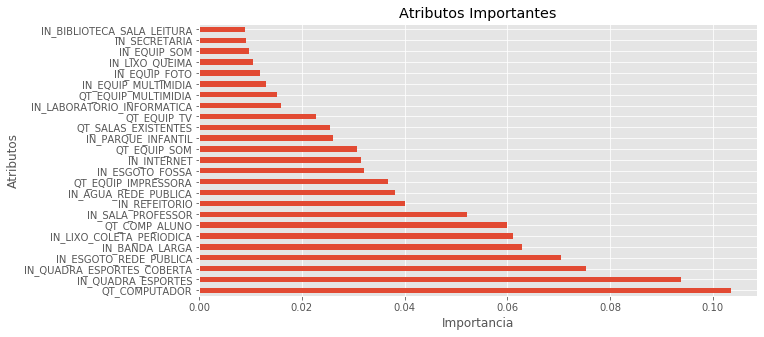

In [93]:
importances = pd.Series(model.feature_importances_, X.columns)

plt.style.use("ggplot")
plt.figure(figsize=(10,5))

importances.nlargest(25).plot(kind='barh', title="Atributos Importantes" )

plt.xlabel('Importancia')
plt.ylabel('Atributos')
plt.show()